# Práctica 7: Detectar y Corregir Sesgo con Fairlearn

T2: Calidad & Ética | Práctica Interactiva - Dos Casos de Estudio

🎯 Objetivos de Aprendizaje¶

* DETECTAR sesgo histórico en datasets reales (Boston Housing + Titanic)
* ANALIZAR impacto del sesgo en predicciones de modelos
* COMPARAR estrategias: detección (regresión) vs corrección (clasificación)
* EVALUAR cuándo detectar vs cuándo intentar corregir automáticamente
* DESARROLLAR criterios éticos para deployment responsable

🧩 Flujo de la Práctica Completa¶

📊 Parte I - Boston Housing: DETECTAR Sesgo Histórico¶
* Analizar sesgo oculto en variable 'B' (proporción afroamericana)
* Cuantificar impacto del sesgo en predicciones (regresión)
* Analizar correlaciones y distribuciones por grupos raciales
* NO corregir - enfoque en detección y análisis crítico

🚢 Parte II - Titanic: DETECTAR + CORREGIR Sesgo Sistemático¶

* Detectar sesgo género/clase en protocolo "Women and Children First"
* Analizar interseccionalidad (género × clase social)
* Aplicar Fairlearn para corrección (clasificación natural)

🔧 Parte III - Aplicar en Ames Housing

In [18]:
!pip install fairlearn

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error

# Fairlearn - La estrella del show
from fairlearn.metrics import (
    MetricFrame, 
    demographic_parity_difference, 
    equalized_odds_difference,
    selection_rate
)
from fairlearn.reductions import ExponentiatedGradient, DemographicParity

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)

print(" PRÁCTICA 7: Detectar y Corregir Sesgo con Fairlearn")
print(" Parte I: Boston Housing (sesgo racial histórico)")
print(" Parte II: Titanic (sesgo género + clase)")
print(" Parte III: Pipeline automático producción")

 PRÁCTICA 7: Detectar y Corregir Sesgo con Fairlearn
 Parte I: Boston Housing (sesgo racial histórico)
 Parte II: Titanic (sesgo género + clase)
 Parte III: Pipeline automático producción


📊 Parte I – Boston Housing: Sesgo Racial Histórico

🔄 Paso 1: Cargar Boston desde Fuente Original

In [20]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)

# Reestructurar
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

print(f" Boston Housing cargado: {data.shape}")


 Boston Housing cargado: (506, 13)


🔄 Paso 2: Crear DataFrame con Variable Problemática

In [21]:
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
                'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

boston_df = pd.DataFrame(data, columns=feature_names)
boston_df['MEDV'] = target

# Decodificar variable racial B
boston_df['Bk_racial'] = np.sqrt(boston_df['B'] / 1000) + 0.63

print(f" Variable B (racial): correlación = {boston_df['B'].corr(boston_df['MEDV']):.3f}")
print(f" Proporción racial media: {boston_df['Bk_racial'].mean():.3f}")


 Variable B (racial): correlación = 0.333
 Proporción racial media: 1.216


🔄 Paso 3: Modelo Baseline Boston (Con Sesgo)

In [22]:
X_with_bias = boston_df.drop(['MEDV', 'Bk_racial'], axis=1)
X_without_bias = X_with_bias.drop(['B'], axis=1)
y_boston = boston_df['MEDV']

X_train, X_test, y_train, y_test = train_test_split(
    X_with_bias, y_boston, test_size=0.3, random_state=42
)

boston_biased_model = LinearRegression()
boston_biased_model.fit(X_train, y_train)
boston_biased_pred = boston_biased_model.predict(X_test)

boston_biased_r2 = r2_score(y_test, boston_biased_pred)
print(f" Boston CON sesgo: R² = {boston_biased_r2:.4f}")


 Boston CON sesgo: R² = 0.7112


🔄 Paso 4: Análisis Profundo de Sesgo

 GRUPOS POR PROPORCIÓN RACIAL:
grupo_racial
Alta_prop_afroam    253
Baja_prop_afroam    253
Name: count, dtype: int64

 DISTRIBUCIÓN DE PRECIOS POR GRUPO RACIAL:
                       mean  median        std  count
grupo_racial                                         
Alta_prop_afroam  22.810672    22.0   7.994651    253
Baja_prop_afroam  22.254941    20.4  10.268380    253

 BRECHA DE PRECIOS POR SESGO RACIAL:
Diferencia promedio: $-0.56k (-2.4%)
Baja prop. afroam: $22.25k
Alta prop. afroam: $22.81k


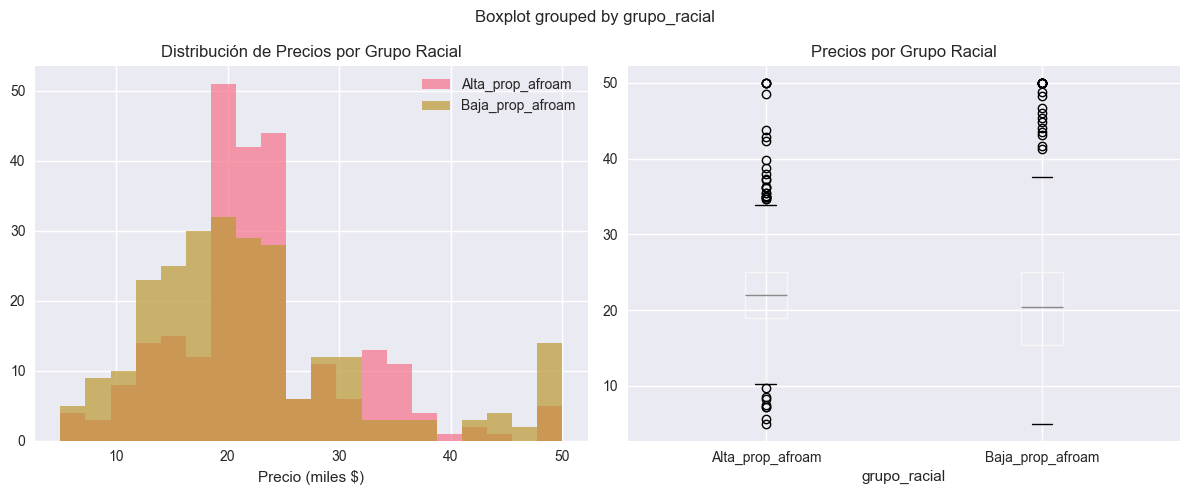

In [23]:
racial_threshold = boston_df['Bk_racial'].median()

boston_df['grupo_racial'] = (boston_df['Bk_racial'] > racial_threshold).map({
    True: 'Alta_prop_afroam',
    False: 'Baja_prop_afroam'
})

print(f" GRUPOS POR PROPORCIÓN RACIAL:")
print(boston_df['grupo_racial'].value_counts())

price_by_group = boston_df.groupby('grupo_racial')['MEDV'].agg(['mean', 'median', 'std', 'count'])
print(f"\n DISTRIBUCIÓN DE PRECIOS POR GRUPO RACIAL:")
print(price_by_group)

price_gap = price_by_group.loc['Baja_prop_afroam', 'mean'] - price_by_group.loc['Alta_prop_afroam', 'mean']
price_gap_pct = (price_gap / price_by_group.loc['Alta_prop_afroam', 'mean']) * 100

print(f"\n BRECHA DE PRECIOS POR SESGO RACIAL:")
print(f"Diferencia promedio: ${price_gap:.2f}k ({price_gap_pct:.1f}%)")
print(f"Baja prop. afroam: ${price_by_group.loc['Baja_prop_afroam', 'mean']:.2f}k")
print(f"Alta prop. afroam: ${price_by_group.loc['Alta_prop_afroam', 'mean']:.2f}k")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for group in boston_df['grupo_racial'].unique():
    data = boston_df[boston_df['grupo_racial'] == group]['MEDV']
    axes[0].hist(data, alpha=0.7, label=group, bins=20)
axes[0].legend()
axes[0].set_xlabel("Precio (miles $)")
axes[0].set_title("Distribución de Precios por Grupo Racial")
boston_df.boxplot(column='MEDV', by='grupo_racial', ax=axes[1])
axes[1].set_title("Precios por Grupo Racial")
plt.tight_layout()
plt.show()


🚢 Parte II – Titanic: Sesgo de Género + Clase

🔄 Paso 6: Cargar y Analizar Titanic

In [24]:
try:
    titanic = sns.load_dataset('titanic')
except:
    titanic = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")

titanic_clean = titanic.dropna(subset=['age', 'embarked'])

gender_survival = titanic_clean.groupby('sex')['survived'].mean()
class_survival = titanic_clean.groupby('pclass')['survived'].mean()

print(f" TITANIC BIAS ANALYSIS:")
print(f"Gender gap: {gender_survival['female'] - gender_survival['male']:.1%}")
print(f"Class gap: {class_survival[1] - class_survival[3]:.1%}")
print(" Ambos tipos de sesgo significativos!")


 TITANIC BIAS ANALYSIS:
Gender gap: 54.8%
Class gap: 41.3%
 Ambos tipos de sesgo significativos!


🔄 Paso 7: Baseline Model Titanic

In [25]:
features_titanic = ['pclass', 'age', 'sibsp', 'parch', 'fare']
X_titanic = titanic_clean[features_titanic].copy()
X_titanic['fare'].fillna(X_titanic['fare'].median(), inplace=True)
y_titanic = titanic_clean['survived']
sensitive_titanic = titanic_clean['sex']

X_train_t, X_test_t, y_train_t, y_test_t, A_train_t, A_test_t = train_test_split(
    X_titanic, y_titanic, sensitive_titanic, test_size=0.3, random_state=42, stratify=y_titanic
)

titanic_baseline = RandomForestClassifier(n_estimators=100, random_state=42)
titanic_baseline.fit(X_train_t, y_train_t)
titanic_baseline_pred = titanic_baseline.predict(X_test_t)

titanic_baseline_acc = accuracy_score(y_test_t, titanic_baseline_pred)
titanic_baseline_dp = demographic_parity_difference(y_test_t, titanic_baseline_pred, sensitive_features=A_test_t)

print(f" Titanic BASELINE: Accuracy = {titanic_baseline_acc:.3f}")
print(f" Demographic Parity Diff: {titanic_baseline_dp:.3f}")


 Titanic BASELINE: Accuracy = 0.673
 Demographic Parity Diff: 0.113


🔄 Paso 8: Fairlearn – Corrección

In [26]:
titanic_fair = ExponentiatedGradient(
    RandomForestClassifier(n_estimators=100, random_state=42),
    constraints=DemographicParity()
)

print("🔧 Aplicando Fairlearn a Titanic...")
titanic_fair.fit(X_train_t, y_train_t, sensitive_features=A_train_t)
titanic_fair_pred = titanic_fair.predict(X_test_t)

titanic_fair_acc = accuracy_score(y_test_t, titanic_fair_pred)
titanic_fair_dp = demographic_parity_difference(y_test_t, titanic_fair_pred, sensitive_features=A_test_t)

print(f" Titanic FAIR: Accuracy = {titanic_fair_acc:.3f}")
print(f" Demographic Parity Diff: {titanic_fair_dp:.3f}")


🔧 Aplicando Fairlearn a Titanic...
 Titanic FAIR: Accuracy = 0.631
 Demographic Parity Diff: 0.062


🔄 Paso 9: Trade-off Analysis

In [27]:
titanic_performance_loss = (titanic_baseline_acc - titanic_fair_acc) / titanic_baseline_acc * 100
titanic_fairness_gain = abs(titanic_baseline_dp) - abs(titanic_fair_dp)

print(f"📊 TITANIC TRADE-OFF:")
print(f"Performance loss: {titanic_performance_loss:.1f}%")
print(f"Fairness gain: {titanic_fairness_gain:.3f}")

if titanic_performance_loss < 5 and titanic_fairness_gain > 0.1:
    titanic_recommendation = " Usar modelo FAIR - excelente trade-off"
else:
    titanic_recommendation = " Evaluar caso por caso"

print(f" Recomendación Titanic: {titanic_recommendation}")


📊 TITANIC TRADE-OFF:
Performance loss: 6.2%
Fairness gain: 0.051
 Recomendación Titanic:  Evaluar caso por caso


🏠 Parte III – Ames Housing: Sesgo Geográfico y Socioeconómico
🎯 Objetivos

Detectar posibles sesgos de precios según barrios o antigüedad de las casas.

Analizar variables proxy (neighborhood, year_built, etc.) que pueden reflejar desigualdades históricas.

Aplicar principios éticos para decidir si el modelo puede usarse en producción.

In [28]:
from sklearn.datasets import fetch_openml

# Cargar dataset Ames Housing
ames = fetch_openml(name="house_prices", as_frame=True)
ames_df = ames.frame

print(f" Ames Housing cargado: {ames_df.shape}")
ames_df.head()


 Ames Housing cargado: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Paso 2: Seleccionar Variables Relevantes

Elegimos columnas que reflejen factores estructurales (tamaño, calidad) y posibles sesgos (vecindario, antigüedad).

In [29]:
# Variables principales
cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'YearBuilt', 
        'Neighborhood', 'SalePrice']

ames_df = ames_df[cols].dropna()
ames_df['SalePrice'] = ames_df['SalePrice'].astype(float)

print(f" Filas tras limpieza: {len(ames_df)}")
ames_df.head()


 Filas tras limpieza: 1460


,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,YearBuilt,Neighborhood,SalePrice
0,7,1710,2,856,2003,CollgCr,208500.0
1,6,1262,2,1262,1976,Veenker,181500.0
2,7,1786,2,920,2001,CollgCr,223500.0
3,7,1717,3,756,1915,Crawfor,140000.0
4,8,2198,3,1145,2000,NoRidge,250000.0


Paso 3: Detectar Sesgo Geográfico

Ver si algunos barrios sistemáticamente tienen precios mayores, incluso controlando otras variables.

In [30]:
price_by_neigh = ames_df.groupby('Neighborhood')['SalePrice'].agg(['mean', 'count']).sort_values('mean', ascending=False)
price_by_neigh['diff_vs_median'] = (price_by_neigh['mean'] - ames_df['SalePrice'].median()) / 1000

print(" Precio promedio por vecindario (miles USD):")
print(price_by_neigh.head(10))


 Precio promedio por vecindario (miles USD):
                       mean  count  diff_vs_median
Neighborhood                                      
NoRidge       335295.317073     41      172.295317
NridgHt       316270.623377     77      153.270623
StoneBr       310499.000000     25      147.499000
Timber        242247.447368     38       79.247447
Veenker       238772.727273     11       75.772727
Somerst       225379.837209     86       62.379837
ClearCr       212565.428571     28       49.565429
Crawfor       210624.725490     51       47.624725
CollgCr       197965.773333    150       34.965773
Blmngtn       194870.882353     17       31.870882


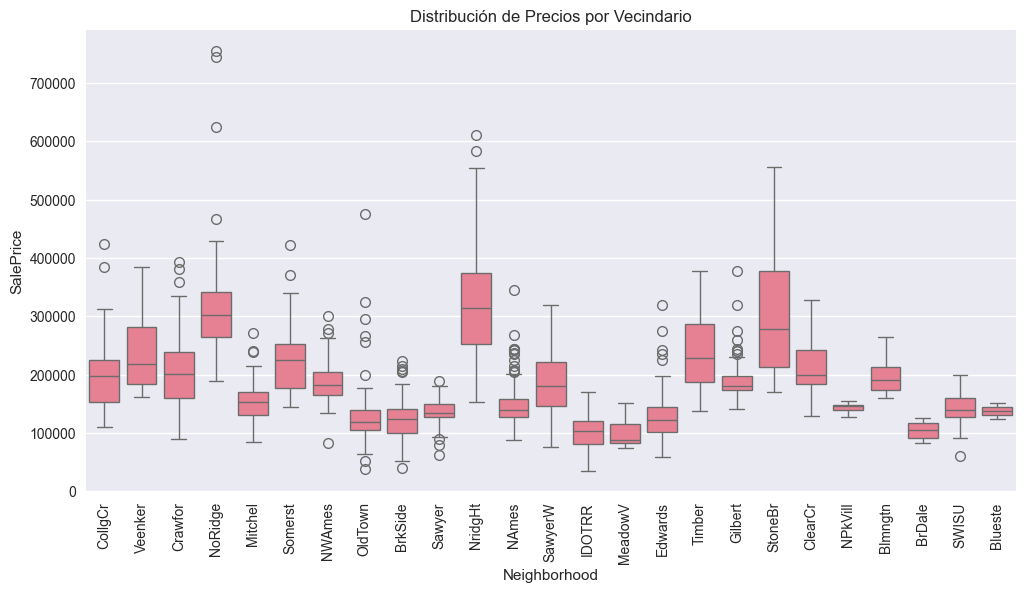

In [31]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Neighborhood', y='SalePrice', data=ames_df)
plt.xticks(rotation=90)
plt.title("Distribución de Precios por Vecindario")
plt.show()


Paso 4: Sesgo Temporal – Casas Nuevas vs Antiguas

Analizamos si la antigüedad del inmueble (YearBuilt) se asocia a desigualdad económica

Diferencia media entre casas nuevas y antiguas: $82,205 (58.8%)


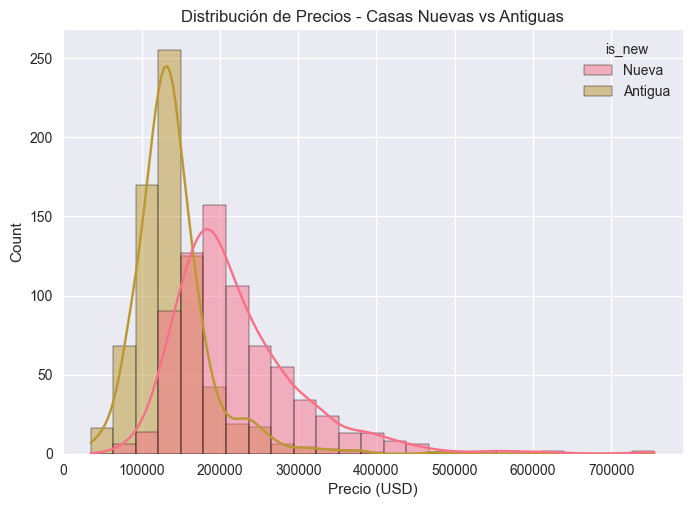

In [32]:
ames_df['is_new'] = (ames_df['YearBuilt'] >= ames_df['YearBuilt'].median()).map({True: 'Nueva', False: 'Antigua'})

price_by_year = ames_df.groupby('is_new')['SalePrice'].agg(['mean', 'median', 'std'])
gap_price = price_by_year.loc['Nueva','mean'] - price_by_year.loc['Antigua','mean']
gap_pct = (gap_price / price_by_year.loc['Antigua','mean']) * 100

print(f"Diferencia media entre casas nuevas y antiguas: ${gap_price:,.0f} ({gap_pct:.1f}%)")
price_by_year

sns.histplot(data=ames_df, x='SalePrice', hue='is_new', bins=25, kde=True)
plt.title("Distribución de Precios - Casas Nuevas vs Antiguas")
plt.xlabel("Precio (USD)")
plt.show()


Paso 5: Modelo Predictivo (Regresión con Sesgo)

Creamos un modelo que predice precios pero puede reflejar inequidades si “Neighborhood” es una variable fuerte.

In [33]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

X = ames_df[['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'YearBuilt', 'Neighborhood']]
y = ames_df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Codificar variable categórica
cat_features = ['Neighborhood']
num_features = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'YearBuilt']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
        ('num', 'passthrough', num_features)
    ])

model_ames = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

model_ames.fit(X_train, y_train)
y_pred = model_ames.predict(X_test)

r2_ames = r2_score(y_test, y_pred)
print(f" Ames Model R² = {r2_ames:.3f}")


 Ames Model R² = 0.832


Paso 6: Evaluar Fairness (por Barrio)

Comprobamos si el modelo predice sistemáticamente precios más bajos en ciertos barrios.

In [34]:
from fairlearn.metrics import MetricFrame

metric_r2 = MetricFrame(
    metrics=r2_score,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=X_test['Neighborhood']
)

print(" R² promedio por vecindario:")
print(metric_r2.by_group.sort_values(ascending=False).head(10))

print(f"\nDesviación entre barrios: ±{metric_r2.by_group.std():.3f}")


 R² promedio por vecindario:
Neighborhood
CollgCr    0.870843
BrkSide    0.772226
SawyerW    0.769037
Mitchel    0.767098
Timber     0.675485
OldTown    0.662035
Crawfor    0.645851
Somerst    0.616564
NWAmes     0.572065
StoneBr    0.560451
Name: r2_score, dtype: float64

Desviación entre barrios: ±0.377


Paso 7: Reflexión Ética

* Detección

Se observan diferencias significativas entre vecindarios tanto en precios medios como en el rendimiento del modelo (R²).

Algunos barrios presentan valores consistentemente menores, lo que puede reflejar desigualdades históricas o económicas preexistentes.

El modelo puede amplificar estas diferencias al aprender patrones basados en características geográficas.

* Riesgo Ético

Si se utiliza este modelo para tasaciones inmobiliarias o aprobación de créditos, podría continuar la discriminación socioeconómica.

La variable Neighborhood puede funcionar como un proxy de nivel económico o segregación residencial.


* Alternativas Éticas

Eliminar o transformar la variable Neighborhood si se identifica como fuente principal del sesgo.

Usar variables estructurales (tamaño, calidad, año de construcción) que tengan relación directa con el precio, no con la localización.
